In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import doctest
import copy

In [2]:
#https://stackoverflow.com/questions/40137950/possible-to-run-python-doctest-on-a-jupyter-cell-function
def test(func):
    '''
    Use test as a decorator to a function with doctests in Jupyter notebook. 
    Run the cell to see the results of the doctests.
    '''
    globs = copy.copy(globals())
    globs.update({func.__name__:func})
    doctest.run_docstring_examples(func, globs, verbose=True, name=func.__name__)
    return func

### Simulate straight line and circular movements with Unicycle model

Robot is at the origin (0, 0) and facing North, i.e, $\theta = \pi/2$

Use the Kinematics equations we had developed in class for the Unicycle model

In [3]:
@test
def unicycle_model(curr_pose, v, w, dt=1.0):
    '''
    >>> unicycle_model((0.0,0.0,0.0), 1.0, 0.0)
    (1.0, 0.0, 0.0)
    >>> unicycle_model((0.0,0.0,0.0), 0.0, 1.0)
    (0.0, 0.0, 1.0)
    >>> unicycle_model((0.0, 0.0, 0.0), 1.0, 1.0)
    (1.0, 0.0, 1.0)
    '''
    ## write code to calculate next_pose
    # refer to the kinematic equations of a unicycle model
    x, y, theta = curr_pose
    x_new = x + v * np.cos(theta) * dt
    y_new = y + v * np.sin(theta) * dt
    theta_new = theta + w * dt
    
    # Keep theta bounded between [-pi, pi]
    theta = np.arctan2(np.sin(theta), np.cos(theta))

    # return newly calculated (x, y, theta)
    return x_new, y_new, theta_new

Finding tests in unicycle_model
Trying:
    unicycle_model((0.0,0.0,0.0), 1.0, 0.0)
Expecting:
    (1.0, 0.0, 0.0)
ok
Trying:
    unicycle_model((0.0,0.0,0.0), 0.0, 1.0)
Expecting:
    (0.0, 0.0, 1.0)
ok
Trying:
    unicycle_model((0.0, 0.0, 0.0), 1.0, 1.0)
Expecting:
    (1.0, 0.0, 1.0)
ok


Now let us try to simulate motion along a straight line and circle

Look at the kinematics equations you wrote - what should $v,\omega$ if
+ There is no change in $\theta$
+ $\theta$ has to change from 0 to 360 degrees

In [4]:
#straight line
straight_trajectory = []
pose = (0, 0, np.pi/2)
steps = 10
straight_trajectory.append(pose)    # Starting pose
#fill in v and omega values
all_v = np.ones(steps)  # 1 m/s throughout
all_w = np.zeros(steps) # 0 rad/s throughout
for v, w in zip(all_v, all_w):
   # Calculate and store new pose
   pose = unicycle_model(pose, v, w)
   straight_trajectory.append(pose)
# Convert to numpy array
straight_trajectory = np.array(straight_trajectory)

In [5]:
#circle
circular_trajectory = []
pose = (0, 0, np.pi/2)
steps = 1000    # More discrete than a straight line
circular_trajectory.append(pose)
#fill in v and omega values
all_v = np.ones(steps)  # 1 m/s forward
all_w = np.ones(steps)  # 1 rad/s rotate => Rad of rotation = 1 m
for v, w in zip(all_v, all_w):
   # Get new pose
   pose = unicycle_model(pose, v, w, 0.1)   # dt=0.1 for smaller steps => smooth
   circular_trajectory.append(pose)
circular_trajectory = np.array(circular_trajectory)
    

**Plot straight and circular trajectories**

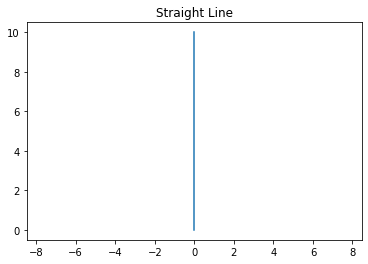

In [6]:
# Straight line
plt.figure()
plt.title("Straight Line")
plt.axis('off')
# https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_aspect.html#matplotlib.axes.Axes.set_aspect
plt.axes().set_aspect("equal", "datalim")   # Equal axis
plt.plot(straight_trajectory[:, 0], straight_trajectory[:, 1])
plt.show()

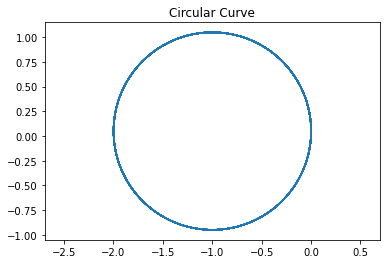

In [7]:
# Circular curve
plt.figure()
plt.title("Circular Curve")
plt.axis('off')
plt.axes().set_aspect("equal", "datalim")   # Equal axis
plt.plot(circular_trajectory[:, 0], circular_trajectory[:, 1])
plt.show()

### Simulate Unicycle model with Open Loop control

We want the robot to follow these instructions

**straight 10m, right turn, straight 5m, left turn, straight 8m, right turn**

It is in open loop; control commands have to be calculated upfront. How do we do it?

To keep things simple in the first iteration, we can fix $v = v_c$ and change only $\omega$. To make it even simpler, $\omega$ can take only 2 values 
+ 0 when the vehicle is going straight 
+ $\omega = \omega_c$ when turning

This leaves only 2 questions to be answered
* What should be $v_c$ and $\omega_c$?
* When should $\omega$ change from 0 and back?

In [8]:
vc = 1 #m/s
wc = np.pi/6 #rad/s

#calculate time taken to finish a quarter turn (pi/2)
t_turn = np.ceil( (np.pi/2)/wc ).astype('int')

#calculate the time taken to finish straight segments
# omega array is to be padded with equivalent zeros

t_straight1, t_straight2, t_straight3 = int(10/vc), int(5/vc), int(8/ vc)

all_w = [0]*t_straight1 + [wc]*t_turn + \
        [0]*t_straight2 + [wc]*t_turn + \
        [0]*t_straight3 + [-wc]*t_turn

all_v = vc*np.ones_like(all_w)

Let us make a cool function out of this!

Take in as input a generic route and convert it into open-loop commands

Input format: [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]

Output: all_v, all_w

In [9]:
def get_open_loop_commands(route, vc=1, wc=np.pi/12, dt=1.0):
    all_w = np.array([])
    ang_speed = {
        "straight": 0.0,
        "left": wc,
        "right": -wc
    }
    for (command, value) in route:
        if (command in ["left", "right"]):
            value = np.deg2rad(value)
        time_cmd = value / (vc if command == "straight" else wc)
        t_val = int(np.ceil(time_cmd))
        all_w = np.append(all_w, [ang_speed[command]] * t_val)
    all_v = vc * np.ones_like(all_w)
    return all_v, all_w

### Unit test your function with the following inputs

+ [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]
+ $v_c = 1$
+ $w_c = \pi/12$

In [10]:
all_v, all_w = get_open_loop_commands([("straight", 5), ("right", 90), ("straight", 6), ("left", 85)])

In [11]:
robot_trajectory = []
all_v, all_w = get_open_loop_commands([("straight", 5), ("right", 90), ("straight", 6), ("left", 85)])
pose = (0, 0, np.pi/2)
robot_trajectory.append(pose)
for v, w in zip(all_v, all_w):
    # Get new pose
    pose = unicycle_model(pose, v, w)
    robot_trajectory.append(pose)
robot_trajectory = np.array(robot_trajectory)

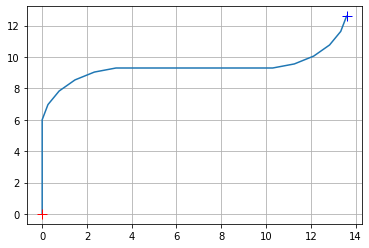

In [12]:
# plot robot trajectory
plt.figure()
plt.grid()
plt.plot(robot_trajectory[:, 0], robot_trajectory[:, 1])

#show first and last robot positions with + markers
xi, yi, _ = robot_trajectory[0]
xf, yf, _ = robot_trajectory[-1]
plt.plot(xi, yi, 'r+', ms=10)
plt.plot(xf, yf, 'b+', ms=10)


### Improved capabilities!

+ Slow the robot while turning ($v_c$ for turn and straight needed)

+ How to accommodate a sampling time < 1.0s (hint: think of sampling instances instead of time)

#### Different turning velocities

Simply change how `all_v` is calculated during turns

In [13]:
def get_open_loop_commands_improved(route, vc=1, vc_turn = 0.2, wc=np.pi/12, 
                                    dt=1.0):
    all_w = np.array([])
    all_v = np.array([])
    ang_speed = {
        "straight": 0.0,
        "left": wc,
        "right": -wc
    }
    lin_speed = {
        "straight": vc,
        "left": vc_turn,
        "right": vc_turn
    }
    for (command, value) in route:
        if (command in ["left", "right"]):
            value = np.deg2rad(value)
        time_cmd = value / (vc if command == "straight" else wc)
        t_val = int(np.ceil(time_cmd))
        all_w = np.append(all_w, [ang_speed[command]] * t_val)
        all_v = np.append(all_v, [lin_speed[command]] * t_val)
    return all_v, all_w

Recalculate everything as before

In [14]:
robot_trajectory = []
all_v, all_w = get_open_loop_commands_improved([("straight", 5), ("right", 90), 
                                                ("straight", 6), ("left", 85)])
pose = (0, 0, np.pi/2)
robot_trajectory.append(pose)
for v, w in zip(all_v, all_w):
    # Get new pose
    pose = unicycle_model(pose, v, w)
    robot_trajectory.append(pose)
robot_trajectory = np.array(robot_trajectory)

**Plot results**

Note that the velocity during turning is slower here, so turns will be faster

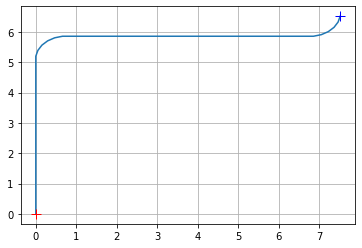

In [15]:
# plot robot trajectory
plt.figure()
plt.grid()
plt.plot(robot_trajectory[:, 0], robot_trajectory[:, 1])

#show first and last robot positions with + markers
xi, yi, _ = robot_trajectory[0]
xf, yf, _ = robot_trajectory[-1]
plt.plot(xi, yi, 'r+', ms=10)
plt.plot(xf, yf, 'b+', ms=10)

#### Sampling Rate

Just multiply samples (no interpolation or anything else here). Remember to pass the new `dt` value to the `unicycle_model` function

In [16]:
def get_open_loop_commands_sampled(route, vc=1, vc_turn = 0.2, wc=np.pi/12, 
                                   sr=0.5):
    all_w = np.array([])
    all_v = np.array([])
    ang_speed = {
        "straight": 0.0,
        "left": wc,
        "right": -wc
    }
    lin_speed = {
        "straight": vc,
        "left": vc_turn,
        "right": vc_turn
    }
    for (command, value) in route:
        if (command in ["left", "right"]):
            value = np.deg2rad(value)
        time_cmd = value / (vc if command == "straight" else wc)
        t_val = int(np.ceil(time_cmd) * sr)
        all_w = np.append(all_w, [ang_speed[command]] * t_val)
        all_v = np.append(all_v, [lin_speed[command]] * t_val)
    return all_v, all_w

Recalculate everything as before

In [17]:
robot_trajectory = []
new_dt = 0.5    # new value of dt being used
all_v, all_w = get_open_loop_commands_sampled([("straight", 5), ("right", 90), 
                                                ("straight", 6), ("left", 85)], 
                                              sr=(1/new_dt))
pose = (0, 0, np.pi/2)
robot_trajectory.append(pose)
for v, w in zip(all_v, all_w):
    # Get new pose
    pose = unicycle_model(pose, v, w, dt=new_dt)
    robot_trajectory.append(pose)
robot_trajectory = np.array(robot_trajectory)

**Plot results**

Note that the velocity during turning is slower here, so turns will be faster

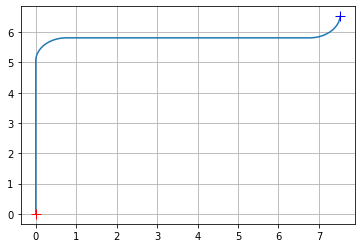

In [18]:
# plot robot trajectory
plt.figure()
plt.grid()
plt.plot(robot_trajectory[:, 0], robot_trajectory[:, 1])

#show first and last robot positions with + markers
xi, yi, _ = robot_trajectory[0]
xf, yf, _ = robot_trajectory[-1]
plt.plot(xi, yi, 'r+', ms=10)
plt.plot(xf, yf, 'b+', ms=10)

In [19]:
print(f"all_v.shape = {all_v.shape}")

all_v.shape = (46,)
